In [1]:
from rdkit import Chem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG
import time
print(time.asctime())
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import EditableMol

Thu Nov  1 15:05:44 2018


In [2]:
mol = Chem.MolFromSmiles("CN1C(CC(O)C1=O)C1=CN=CC=C1")

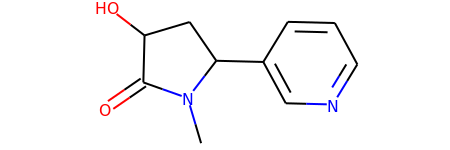

In [3]:
mol

In [4]:
for atom in mol.GetAtoms():
    print(atom.GetImplicitValence(), atom.GetExplicitValence(), len(atom.GetBonds()))

3 1 1
0 3 3
1 3 3
2 2 2
1 3 3
1 1 1
0 4 3
0 2 1
0 4 3
1 3 2
0 3 2
1 3 2
1 3 2
1 3 2


In [5]:
import pickle

def add_atom(mol, atomic_numbers=[6,7,8,16,17]):
    new_mols = []
    for atomic_number in atomic_numbers:
        for atom in mol.GetAtoms():
            if atom.GetImplicitValence() == 0:
                continue
            emol = EditableMol(mol)
            new_index = emol.AddAtom(Chem.Atom(atomic_number))
            emol.AddBond(atom.GetIdx(), new_index, Chem.BondType.SINGLE)
            m2 = emol.GetMol()
            Chem.SanitizeMol(m2)
            new_mols.append(m2)
    return new_mols

def sanitize_emol(emol):
    try:
        m2 = emol.GetMol()
        Chem.SanitizeMol(m2)
        return m2
    except:
        return None

def add_bond_helper(mol, a1, a2, bond_type):
    emol = EditableMol(mol)
    emol.AddBond(a1.GetIdx(), a2.GetIdx(), bond_type)
    return sanitize_emol(emol)

def mutate_bond(mol, bond, bond_type):
    my_mol = deep_copy_mol(mol)
    my_bond = my_mol.GetBondWithIdx(bond.GetIdx())
    my_bond.SetBondType(bond_type)
    Chem.SanitizeMol(my_mol)
    return my_mol

def add_bond_for_atoms(mol, a1, a2):
    v1, v2 = a1.GetImplicitValence(), a2.GetImplicitValence()
    bond = mol.GetBondBetweenAtoms(a1.GetIdx(), a2.GetIdx())
    new_mols = []
    if bond is None:
        new_mols.append(add_bond_helper(mol, a1, a2, Chem.BondType.SINGLE))
        if v1 > 1 and v2 > 1:
            new_mols.append(add_bond_helper(mol, a1, a2, Chem.BondType.DOUBLE))
        if v1 > 2 and v2 > 2:
            new_mols.append(add_bond_helper(mol, a1, a2, Chem.BondType.TRIPLE))
        return new_mols
    
    
    if bond.GetBondType() == Chem.BondType.SINGLE:
        if v1 > 1 and v2 > 1:
            new_mols.append(mutate_bond(mol, bond, Chem.BondType.DOUBLE))            
        if v1 > 2 and v2 > 2:
            new_mols.append(mutate_bond(mol, bond, Chem.BondType.TRIPLE))
        return new_mols

    if bond.GetBondType() == Chem.BondType.DOUBLE:
        if v1 > 2 and v2 > 2:
            new_mols.append(mutate_bond(mol, bond, Chem.BondType.TRIPLE))
        return new_mols
    return new_mols
        

def add_bond(mol):
    new_mols = []
    num_atoms = mol.GetNumAtoms()
    for i1 in range(num_atoms):
        a1 = mol.GetAtomWithIdx(i1)
        if a1.GetImplicitValence() == 0:
            continue
        for i2 in range(i1+1, num_atoms):
            a2 = mol.GetAtomWithIdx(i2)
            if a2.GetImplicitValence() == 0:
                continue
            new_mols.extend(add_bond_for_atoms(mol, a1, a2))
    return new_mols


def get_sub_mols(mol):
    if mol is None:
        return []
    frags = Chem.rdmolops.GetMolFrags(mol, asMols=True) 
    if len(frags) == 1:
        return frags
    is_one_atom = False
    for frag in frags:
        if frag.GetNumAtoms() == 1:
            is_one_atom = True
    
    if not is_one_atom:
        return []
    
    for frag in frags:
        if frag.GetNumAtoms() != 1:
            return [frag]
        
def create_emol(mol):
    return EditableMol(mol)
    
def deep_copy_mol(mol):
    pkl = pickle.dumps(mol)
    return pickle.loads(pkl)

def remove_bond(mol):
    new_mols = []
    num_atoms = mol.GetNumAtoms()
    for bond in mol.GetBonds():
        original_bond_type = bond.GetBondType()
        
        emol = create_emol(mol)
        emol.RemoveBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx())
        new_mol = sanitize_emol(emol)
        
        new_mols.extend(get_sub_mols(new_mol))
        
        if bond.GetBondType() in [Chem.BondType.DOUBLE, Chem.BondType.TRIPLE]:
            new_mols.append(mutate_bond(mol, bond, Chem.BondType.SINGLE))            
        if bond.GetBondType() == Chem.BondType.TRIPLE:
            new_mols.append(mutate_bond(mol, bond, Chem.BondType.DOUBLE)) 
    return new_mols

def get_all_actions(mol):
    new_mols = [mol]
    new_mols.extend(add_atom(mol))
    new_mols.extend(add_bond(mol))
    new_mols.extend(remove_bond(mol))
    
    # Note (Leswing): There be duplicates in here
    new_mols = [x for x in new_mols if x is not None]
    for mol in new_mols:
        Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SANITIZE_KEKULIZE)
    return new_mols


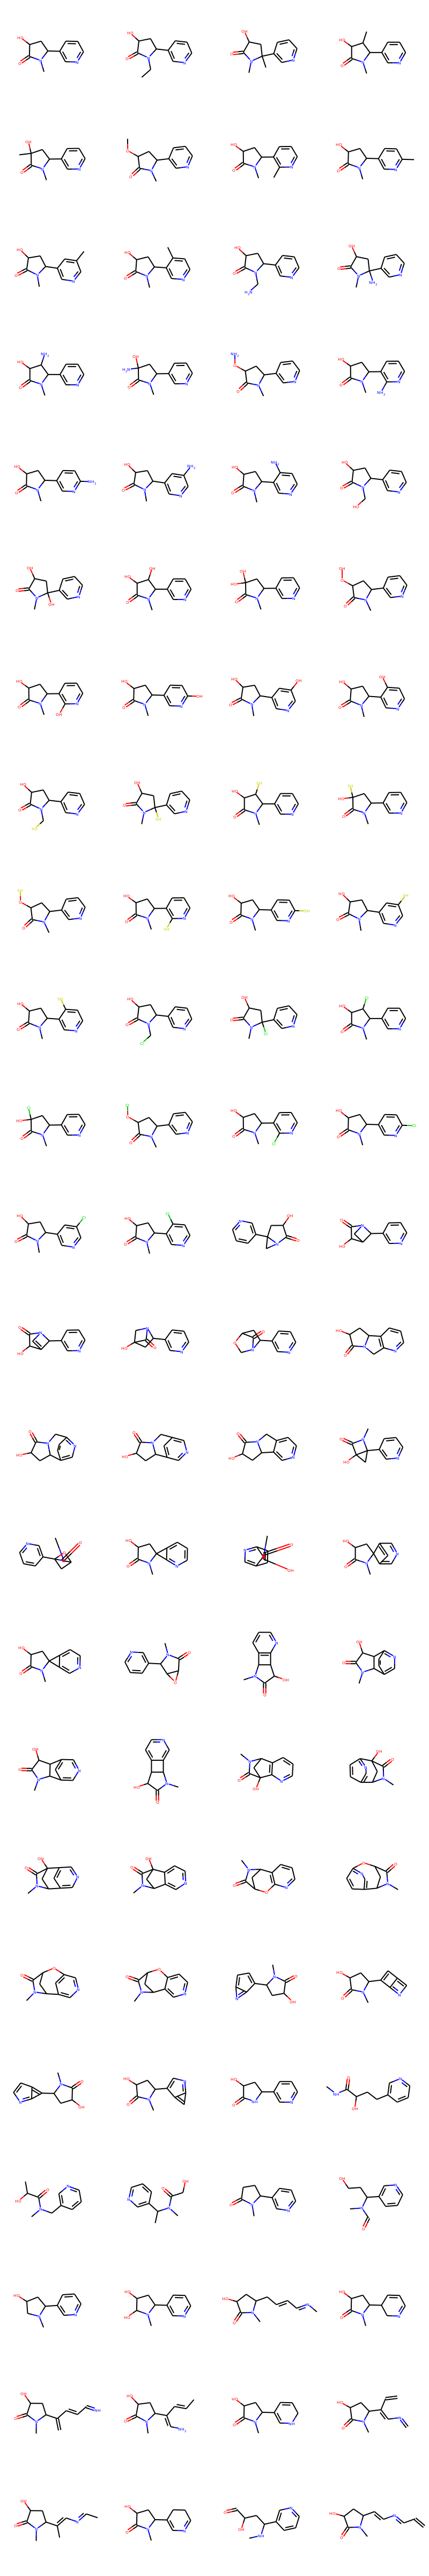

In [6]:
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
import matplotlib.pyplot as plt
%matplotlib inline
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import FunctionalGroups
import numpy as np

Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SANITIZE_KEKULIZE)
new_mols = get_all_actions(mol)
Draw.MolsToGridImage(new_mols,molsPerRow=4, maxMols=100)

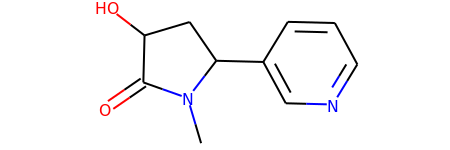

In [7]:
mol

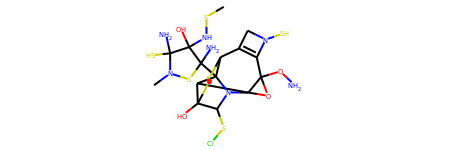

In [8]:
import random
def random_walk(mol, steps=40):
    for i in range(steps):
        new_mols = get_all_actions(mol)
        mol = random.choice(new_mols)
        Chem.SanitizeMol(mol, sanitizeOps=Chem.rdmolops.SANITIZE_KEKULIZE)
    return mol
random_walk(mol)

In [9]:
from rdkit.Chem import Descriptors

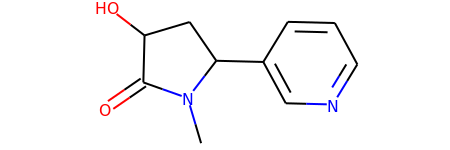

In [10]:
mol